# Simulating DCT Transform with CNN

2020-10-08 Chen-hsiu Huang

This notebook uses a typical [convolutional auto-encoder](https://blog.keras.io/building-autoencoders-in-keras.html) (CAE) to simulate the forward and inverse DCT transform used in JPEG image compression. To completely mimic DCT transform, I use the same 8x8 image block as JPEG's 8x8 DCT transform and design the bottleneck layer as a 64-dimensional vector, which is the same as a typical 8x8 DCT coefficient block. Let's see how good a CNN can approximate the DCT transform.  

First of all, let's import the necessary modules and define some helper functions. 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision.datasets.vision import VisionDataset
from torchvision import transforms
from PIL import Image
import scipy
import numpy as np
from torch.optim import Adam
from torch.autograd import Variable
import sys
import glob
import random
import datetime
import skimage.metrics
from matplotlib import pyplot as plt 

random.seed(datetime.datetime.now())

def dct2(a):
    return scipy.fft.dct( scipy.fft.dct( a, axis=0, norm='ortho' ), axis=1, norm='ortho' )

def idct2(a):
    return scipy.fft.idct( scipy.fft.idct( a, axis=0 , norm='ortho'), axis=1 , norm='ortho')

def non_overlap_crop(im, patch_size=64, stride=64):
    w, h = im.size
    patches = []
    dcts = []
    rects = []
    for i in range(0, h, stride):
        if i + stride > h:
            continue
        for j in range(0, w, stride):
            if j + stride > w:
                continue
            # minus 128 for JPEG level shift
            px = np.array(im.crop((j, i, j + patch_size, i + patch_size)), dtype=int) - 128
            dcts.append(dct2(px))
            patches.append(px)
            rects.append((j, i))
    return patches, dcts, rects

def predict_image(model, patches, batch_size):
    re_px = []
    re_dct = []
    with torch.no_grad():
        for i in range(0, len(patches), batch_size):
            patch = patches[i:i + batch_size]
            patch = torch.stack(patch).to(device)
            r, c = model(patch)
            r = r.squeeze(1).cpu().numpy() + 128    # JPEG level shift
            r = r.round().clip(0, 255).astype(np.uint8)
            c = c.cpu().numpy()
            
            for j in range(r.shape[0]):
                re_px.append(r[j])
                re_dct.append(c[j])
    return re_px, re_dct

def reconstruct_image(re_px, rects, im_size):
    canvas = Image.new('L', im_size)
    for i in range(len(re_px)):
        pos = rects[i]
        px = Image.fromarray(re_px[i])
        canvas.paste(px, (pos[0], pos[1], pos[0] + BK_SIZE, pos[1] + BK_SIZE))
    return canvas

def estimate_image(re_px, re_dct, patches, dcts, rects, im):
    canvas = Image.new('L', im.size)
    err_px, err_dct = 0, 0
    for i in range(len(re_px)):
        pos = rects[i]
        rpx = Image.fromarray(re_px[i])
        px = patches[i].squeeze(0).cpu().numpy().astype(int) + 128    # JPEG level shift
        dct = dcts[i].numpy()
        rdct = re_dct[i]
        err_px += (np.linalg.norm(px - rpx, ord=1) / (BK_SIZE * BK_SIZE))
        err_dct += (np.linalg.norm(dct - rdct, ord=1) / (BK_SIZE * BK_SIZE))
        canvas.paste(rpx, (pos[0], pos[1], pos[0] + BK_SIZE, pos[1] + BK_SIZE))
    err_px /= len(patches)
    err_dct /= len(patches)
    psnr = skimage.metrics.peak_signal_noise_ratio(np.array(im), np.array(canvas))
    return psnr, err_px, err_dct

## Network Architecture

Here I use two convolution layers of 3x3 kernel size in both encoder and decoder. In the encoder, I do not down-sample the input image for dimension reduction like the typical auto-encoder setting, but use two fully connected layers to generate the 64-dimensional vector as latent code (bottleneck layer). Our goal is to approximate the DCT transform so that the reconstructed 8x8 image is similar to the input image, and the latent code is very close to the transformed 8x8 DCT coefficients. 

In [2]:
EPOCHS = 20
BK_SIZE = 8
BATCH_SIZE = 256
MODEL_FILE = 'pseudo_trans.pth'
F1 = 32
F2 = 16

class JDCTNet(nn.Module):
    def __init__(self):
        super(JDCTNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, F1, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(F1, F2, 3, padding=1),
            nn.ReLU(),
        )
        self.c1 = nn.Linear((BK_SIZE * BK_SIZE) * F2, BK_SIZE * BK_SIZE)
        self.c2 = nn.Linear(BK_SIZE * BK_SIZE, (BK_SIZE * BK_SIZE) * F2)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(F2, F1, 1, stride=1),
            nn.ReLU(),
            nn.ConvTranspose2d(F1, 1, 1, stride=1),
            #nn.ReLU(),     # need to preserve the negative value after level shift
        )

    def encode(self, x):
        x = self.encoder(x)
        return x

    def decode(self, x):
        x = self.decoder(x)
        return x

    def forward(self, x):
        x = self.encode(x)
        h = torch.flatten(x, 1)
        c = self.c1(h)
        h = self.c2(c)
        h = h.view(-1, F2, BK_SIZE, BK_SIZE)
        r = self.decode(h)
        return r, c

## Dataset

Now we need some images for training and testing. I choose the [UCID dataset](https://www.spiedigitallibrary.org/conference-proceedings-of-spie/5307/0000/UCID-an-uncompressed-color-image-database/10.1117/12.525375.full) to train our CNN<sup>1</sup>, and the [Kodak dataset](http://r0k.us/graphics/kodak/) is for testing. The training set gives us 2.7 million 8x8 patches to train our CNN. Then we verify the approximation result on the 24 images of Kodak. 

<sup>1</sup> The link in the original paper is not working. [This link](http://jasoncantarella.com/downloads/ucid.v2.tar.gz) works, but the file seems broken. I can only extract 886 images from it. 

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class JDCTDataset(VisionDataset):
    def __init__(self, root, is_train=True, max_items=-1, transform=None, target_transform=None):
        super(JDCTDataset, self).__init__(root, transform=transform, target_transform=target_transform)
        
        self.im_names = glob.glob(self.root)
        if max_items != -1:
            random.shuffle(self.im_names)
            self.im_names = self.im_names[:max_items]
        self.patches = [] 
        self.dcts = []
        self.rects = []
        self.images = []
        for i, im_name in enumerate(self.im_names):
            sys.stderr.write(f'load {i+1}/{len(self.im_names)} image\r')
            im = Image.open(im_name).convert('L')
            patches, dcts, rects = non_overlap_crop(im, BK_SIZE, BK_SIZE)
            t_patch = ()
            t_dct = ()
            for j in range(len(patches)):
                t_patch = t_patch + (torch.from_numpy(patches[j]).float().unsqueeze(0), )
                t_dct = t_dct + (torch.from_numpy(dcts[j]).float().view(BK_SIZE * BK_SIZE),)
            if is_train:
                self.patches += t_patch
                self.dcts += t_dct
            else:
                self.patches.append(t_patch)
                self.dcts.append(t_dct)
                self.rects.append(rects)
                self.images.append(im)
        print(f'load from {root}, {len(self.im_names)} images, {len(self.patches)} items')

    def __len__(self):
        return len(self.patches)

    def __getitem__(self, idx):
        return self.patches[idx], self.dcts[idx]

test_dataset = JDCTDataset('/home/chenhsiu/dataset/kodak/*.png', is_train=False)

train_dataset = JDCTDataset('/home/chenhsiu/dataset/ucid/*.png', is_train=True, max_items=-1)
loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)

load from /home/chenhsiu/dataset/kodak/*.png, 24 images, 24 items


load from /home/chenhsiu/dataset/ucid/*.png, 886 images, 2721792 items


## Loss Function and Training 

I design the loss function as the sum of reconstruction error plus L1 loss between latent code and DCT coefficients. We train our network for 20 epochs, and the best one gives us an average PSNR 65.4745 on the Kodak dataset. Given there is no quantization error, the PSNR value of 65.4745 remains pretty high, and the reconstruction error is only 0.0089 per-pixel, which is very close to the original image. 

Train Epoch: 1/20 [None] Average loss: 2.7352812        


Test  Epoch: 1/20 [None] PSNR: 50.5277, pixel error: 0.0937 DCT error: 0.4114                   


Train Epoch: 2/20 [1] Average loss: 1.0488402        


Test  Epoch: 2/20 [1] PSNR: 52.6990, pixel error: 0.0679 DCT error: 0.3050                   


Train Epoch: 3/20 [2] Average loss: 0.8532402        


Test  Epoch: 3/20 [2] PSNR: 54.5436, pixel error: 0.0506 DCT error: 0.2497                   


Train Epoch: 4/20 [3] Average loss: 0.7363109        


Test  Epoch: 4/20 [3] PSNR: 53.0763, pixel error: 0.0722 DCT error: 0.2325                   


Train Epoch: 5/20 [3] Average loss: 0.6509473        


Test  Epoch: 5/20 [3] PSNR: 53.2266, pixel error: 0.0635 DCT error: 0.1992                   


Train Epoch: 6/20 [5] Average loss: 0.5992452        


Test  Epoch: 6/20 [5] PSNR: 54.0174, pixel error: 0.0606 DCT error: 0.1868                   


Train Epoch: 7/20 [6] Average loss: 0.5553703        


Test  Epoch: 7/20 [6] PSNR: 59.4127, pixel error: 0.0263 DCT error: 0.1575                   


Train Epoch: 8/20 [7] Average loss: 0.5264557        


Test  Epoch: 8/20 [7] PSNR: 58.0341, pixel error: 0.0311 DCT error: 0.1805                   


Train Epoch: 9/20 [7] Average loss: 0.4930655        


Test  Epoch: 9/20 [7] PSNR: 60.2368, pixel error: 0.0218 DCT error: 0.1473                   


Train Epoch: 10/20 [9] Average loss: 0.4701522        


Test  Epoch: 10/20 [9] PSNR: 58.9712, pixel error: 0.0249 DCT error: 0.1375                   


Train Epoch: 11/20 [10] Average loss: 0.4492505        


Test  Epoch: 11/20 [10] PSNR: 56.1293, pixel error: 0.0432 DCT error: 0.1433                   


Train Epoch: 12/20 [10] Average loss: 0.4297634        


Test  Epoch: 12/20 [10] PSNR: 64.8727, pixel error: 0.0105 DCT error: 0.1063                   


Train Epoch: 13/20 [12] Average loss: 0.4135378        


Test  Epoch: 13/20 [12] PSNR: 62.2089, pixel error: 0.0152 DCT error: 0.1325                   


Train Epoch: 14/20 [12] Average loss: 0.3988915        


Test  Epoch: 14/20 [12] PSNR: 62.0750, pixel error: 0.0154 DCT error: 0.1198                   


Train Epoch: 15/20 [12] Average loss: 0.3839271        


Test  Epoch: 15/20 [12] PSNR: 65.4745, pixel error: 0.0089 DCT error: 0.1063                   


Train Epoch: 16/20 [15] Average loss: 0.3751442        


Test  Epoch: 16/20 [15] PSNR: 63.6348, pixel error: 0.0119 DCT error: 0.1118                   


Train Epoch: 17/20 [15] Average loss: 0.3632353        


Test  Epoch: 17/20 [15] PSNR: 65.0809, pixel error: 0.0098 DCT error: 0.1129                   


Train Epoch: 18/20 [15] Average loss: 0.3553261        


Test  Epoch: 18/20 [15] PSNR: 61.3105, pixel error: 0.0190 DCT error: 0.0966                   


Train Epoch: 19/20 [15] Average loss: 0.3460643        


Test  Epoch: 19/20 [15] PSNR: 62.2349, pixel error: 0.0164 DCT error: 0.1025                   


Train Epoch: 20/20 [15] Average loss: 0.3392904        


Test  Epoch: 20/20 [15] PSNR: 65.8145, pixel error: 0.0086 DCT error: 0.1118                   


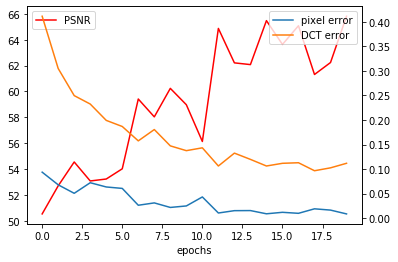

In [4]:
model = JDCTNet().to(device)
optimizer = Adam(model.parameters(), lr=1e-3)

hist_psnr = []
hist_err_px = []
hist_err_dct = []
best_epoch = None
best_cond = 0

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    str_epoch = f'Epoch: {epoch+1}/{EPOCHS} [{best_epoch}]'
    for batch_idx, (x, y) in enumerate(loader):
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        r, c = model(x)
        loss = F.l1_loss(x, r) + F.l1_loss(c, y)
        train_loss += loss.data.item()
        loss.backward()
        optimizer.step()
        sys.stderr.write(f'==>   {str_epoch} - ' + 
                         f'{batch_idx * BATCH_SIZE * 100 / len(train_dataset):.2f}% ' +
                         f'loss: {loss.data.item():.6f}        \r')
    
    train_loss /= (batch_idx + 1)
    sys.stderr.write(f'Train {str_epoch} Average loss: {train_loss:.6f}\n')

    model.eval()
    psnr, err_px, err_dct = 0, 0, 0
    for i in range(len(test_dataset)):
        patches, dcts = test_dataset[i]
        re_px, re_dct = predict_image(model, patches, BATCH_SIZE*10)
        _psnr, _e_px, _e_dct = estimate_image(re_px, re_dct, patches, dcts, 
                                              test_dataset.rects[i], test_dataset.images[i])
        psnr += _psnr
        err_px += _e_px
        err_dct += _e_dct
        sys.stdout.write(f'==>   {str_epoch} - ' +
                         f'{(i+1)*100/len(test_dataset):.2f}% ' +
                         f'PSNR: {_psnr:.4f}, pixel error: {_e_px:.4f} DCT error: {_e_dct:.4f}         \r')
        
    psnr /= len(test_dataset)
    err_px /= len(test_dataset)
    err_dct /= len(test_dataset)
    hist_psnr.append(psnr)
    hist_err_px.append(err_px)
    hist_err_dct.append(err_dct)
    print(f'Test  {str_epoch} ' + 
          f'PSNR: {psnr:.4f}, pixel error: {err_px:.4f} DCT error: {err_dct:.4f}                  ')
    
    cond = err_px + err_dct
    if best_epoch is None or cond < best_cond:
        best_cond = cond
        best_epoch = epoch + 1
        torch.save(model.state_dict(), MODEL_FILE)

fig, ax1 = plt.subplots()

ax1.plot(hist_psnr, color='red', label='PSNR')
ax1.set_xlabel('epochs')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.plot(hist_err_px, label='pixel error')
ax2.plot(hist_err_dct, label='DCT error')
ax2.legend(loc='upper right')

plt.show()

## Simulation Results

We select one image from the Kodak dataset and see the approximation result. The original image and reconstructed image of PSNR 69.40 are listed below. Ten 8x8 blocks are randomly selected from the image for a detailed comparison. The DCT approximation error is 0.0687 per DCT coefficient, which means the latent code does mimic the energy compaction effect of the DCT transform. 

PSNR: 69.3996, pixel error: 0.0035 DCT error: 0.0687


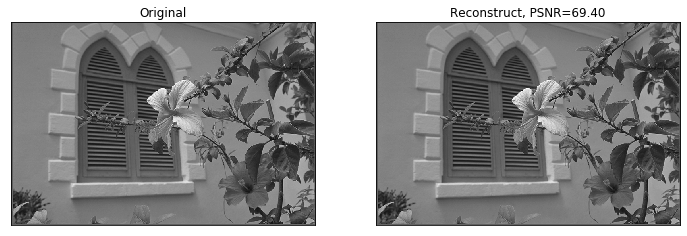

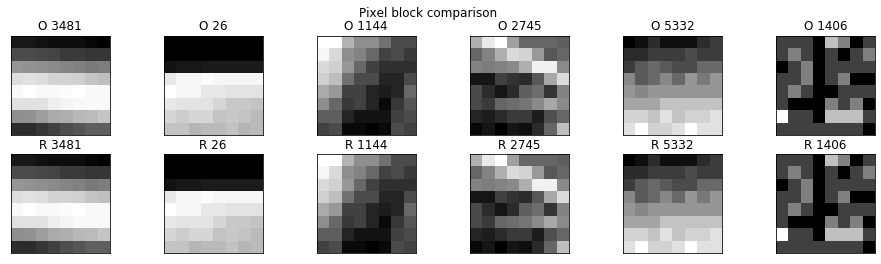

DCT block comparison
block 3481 diff = 
[[ 0 -1  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [-1  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  1  0  0  0  0]
 [ 1  0  0  0  0  0  0  0]]
block 26 diff = 
[[0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]]
block 1144 diff = 
[[ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 -1  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0 -1]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]]
block 2745 diff = 
[[ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 -1]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]]
block 5332 diff = 
[[-1  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 

In [5]:
model.load_state_dict(torch.load(MODEL_FILE))

im_idx = 3
patches, dcts = test_dataset[im_idx]
model.eval()
re_px, re_dct = predict_image(model, patches, BATCH_SIZE*10)
im = reconstruct_image(re_px, test_dataset.rects[im_idx], test_dataset.images[im_idx].size)
psnr, e_px, e_dct = estimate_image(re_px, re_dct, patches, dcts, test_dataset.rects[im_idx], 
                                   test_dataset.images[im_idx])

print(f'PSNR: {psnr:.4f}, pixel error: {e_px:.4f} DCT error: {e_dct:.4f}')

figure, axis = plt.subplots(1, 2, figsize=(12,8))
axis[0].set_title('Original')
axis[0].imshow(test_dataset.images[im_idx], cmap='gray')
axis[0].get_xaxis().set_visible(False)
axis[0].get_yaxis().set_visible(False)
axis[1].set_title(f'Reconstruct, PSNR={psnr:.2f}')
axis[1].imshow(im, cmap='gray')
axis[1].get_xaxis().set_visible(False)
axis[1].get_yaxis().set_visible(False)
plt.show()

COMP_COL = 6
sel = [i for i in range(len(re_px))]
random.shuffle(sel)
sel = sel[:COMP_COL]

figure, axis = plt.subplots(2, COMP_COL, figsize=(16,4))
figure.suptitle('Pixel block comparison')
for i, idx in enumerate(sel):
    px = patches[idx].squeeze(0).cpu().numpy().astype(int)
    axis[0][i].set_title(f'O {idx}')
    axis[0][i].imshow(px, cmap='gray')
    axis[0][i].get_xaxis().set_visible(False)
    axis[0][i].get_yaxis().set_visible(False)
    axis[1][i].set_title(f'R {idx}')
    axis[1][i].imshow(re_px[idx], cmap='gray')
    axis[1][i].get_xaxis().set_visible(False)
    axis[1][i].get_yaxis().set_visible(False)
plt.show()

print('DCT block comparison')
for i, idx in enumerate(sel[:COMP_COL]):
    dct = dcts[idx].squeeze(0).cpu().numpy().astype(int)
    print(f'block {idx} diff = \n{(re_dct[idx] - dct).reshape(BK_SIZE, BK_SIZE).astype(int)}')